In [54]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# ------------------------
# 1. Data Fetching Function
# ------------------------
def get_historical_data(symbol, interval='1d', start_date=None, end_date=None, limit=1000):
    url = f'https://api.binance.com/api/v3/klines'
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit
    }
    
    if start_date:
        params['startTime'] = int(pd.Timestamp(start_date).timestamp() * 1000)
    if end_date:
        params['endTime'] = int(pd.Timestamp(end_date).timestamp() * 1000)
    
    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f'Error fetching data: {response.status_code} - {response.text}')
    
    data = response.json()
    df = pd.DataFrame(data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df.drop(columns=['ignore'], inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    
    return df



# Parameters
symbol = 'ETHUSDT'
interval = '1d'
start_date = '2022-06-01'
end_date = '2025-02-10'

# Fetch and prepare data
df = get_historical_data(symbol, interval, start_date, end_date)




In [55]:
df.shape

(986, 10)

# visualize trends and patterns in the data

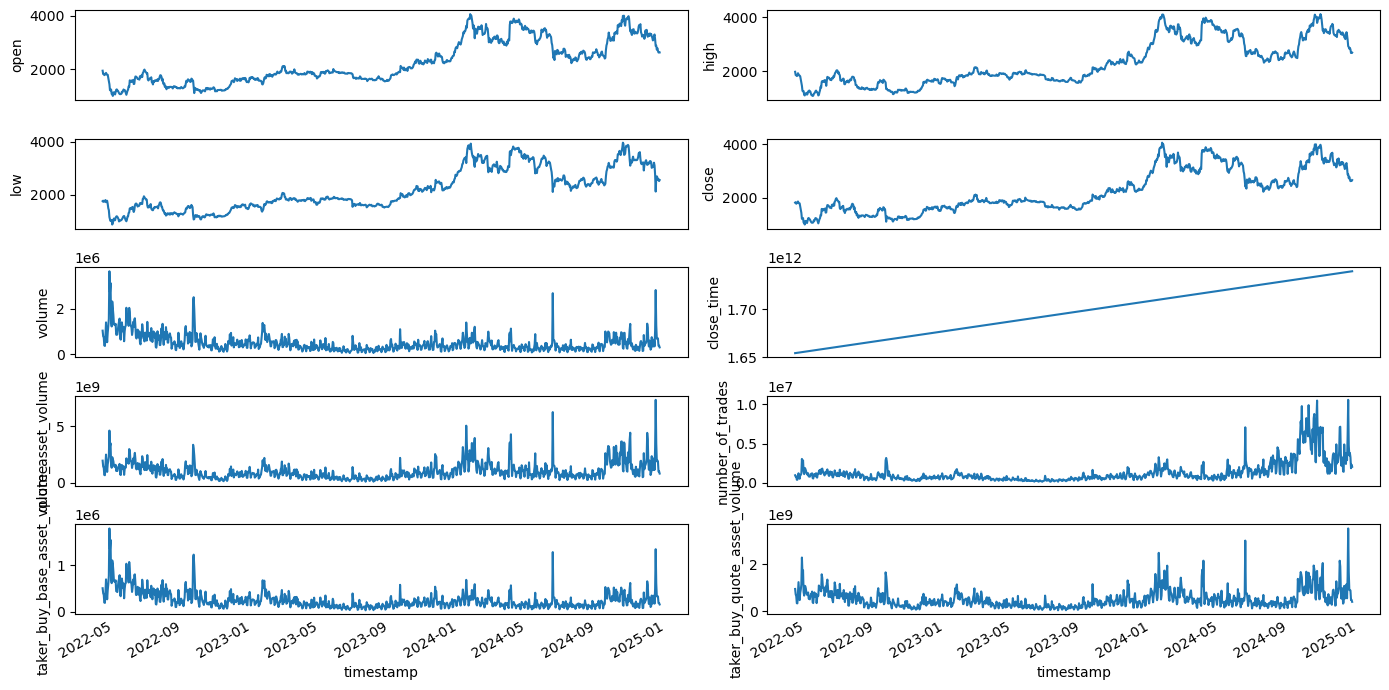

In [56]:
import matplotlib.dates as mdates
import seaborn as sns

def data_plot(df):
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

# Plot the data
data_plot(df)


## Preprocess Data

In [57]:
import math
from sklearn.preprocessing import MinMaxScaler

# Train test split
training_data_len = math.ceil(len(df) * .8)
print(training_data_len)


789


In [58]:
# Splitting the dataset
train_data = df[:training_data_len].iloc[:, :1]
test_data = df[training_data_len:].iloc[:, :1]
print(train_data.shape, test_data.shape)


(789, 1) (197, 1)


In [59]:

# Selecting Open Price values
dataset_train = train_data.open.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)



(789, 1)


In [60]:
# Selecting Open Price values
dataset_test = test_data.open.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)



(197, 1)


In [61]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(scaled_test[:5])

[[0.30842954]
 [0.268054  ]
 [0.27330862]
 [0.2541014 ]
 [0.26369524]]
[[0.5873934 ]
 [0.61409515]
 [0.59247517]
 [0.56635805]
 [0.5498648 ]]


## Create Sequences and Labels for Training and Testing

In [62]:
# Create sequences and labels for training data
sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)



In [63]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

torch.Size([739, 50, 1]) torch.Size([739, 1])


In [64]:
# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])  # Predicting the value right after the sequence
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([167, 30, 1]) torch.Size([167, 1])


# Define and Train the LSTM Model

In [65]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = 1
num_layers = 3  # Increased number of layers
hidden_size = 128  # Increased number of hidden units
output_size = 1
dropout = 0.2  # Added dropout for regularization

model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Learning rate



cpu


In [66]:
batch_size = 32  # Adjusted batch size
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 100  # Increased number of epochs
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/100] - Training Loss: 0.0025, Test Loss: 0.0158
Epoch [20/100] - Training Loss: 0.0019, Test Loss: 0.0122
Epoch [30/100] - Training Loss: 0.0016, Test Loss: 0.0154
Epoch [40/100] - Training Loss: 0.0011, Test Loss: 0.0094
Epoch [50/100] - Training Loss: 0.0011, Test Loss: 0.0065
Epoch [60/100] - Training Loss: 0.0009, Test Loss: 0.0078
Epoch [70/100] - Training Loss: 0.0009, Test Loss: 0.0055
Epoch [80/100] - Training Loss: 0.0014, Test Loss: 0.0048
Epoch [90/100] - Training Loss: 0.0010, Test Loss: 0.0049
Epoch [100/100] - Training Loss: 0.0008, Test Loss: 0.0041


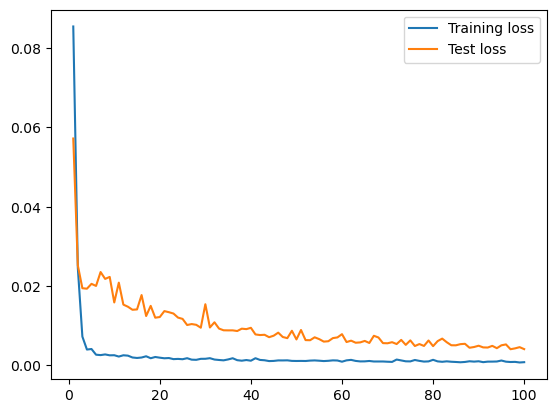

In [67]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

num_forecast_steps = 1
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]
forecasted_values = []

# Generate forecasted values
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.tensor(historical_data, dtype=torch.float32).view(1, -1, 1).to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        print(historical_data)
        historical_data[-1] = predicted_value


[0.59451574 0.5857857  0.51282525 0.56236124 0.68933785 0.60868734
 0.70177805 0.60850185 0.55649805 0.5951678  0.6196547  0.5719064
 0.6256528  0.60984534 0.6147135  0.56628495 0.5380823  0.4792148
 0.49955308 0.5745878  0.6047242  0.5015993  0.36226678 0.36800626
 0.28441575 0.31649157 0.2593667  0.2230973  0.22891545 0.58564514]
[0.23066826]


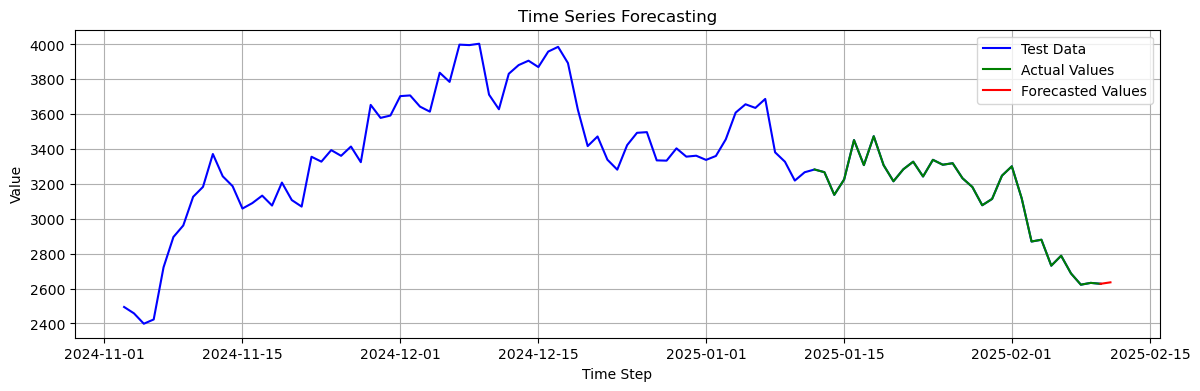

In [72]:



# Generate future dates
last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_forecast_steps)

# Plot the results
plt.figure(figsize=(14, 4))
plt.plot(test_data.index[-100:], test_data.open[-100:], label='Test Data', color='blue')
plt.plot(test_data.index[-30:], test_data.open[-30:], label='Actual Values', color='green')
plt.plot(
    test_data.index[-1:].append(future_dates), 
    np.concatenate([test_data.open[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()]), 
    label='Forecasted Values', 
    color='red'
)

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.show()




In [69]:
# Evaluate the model
model.eval()
test_predictions = []

with torch.no_grad():
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        prediction = model(batch_X_test).cpu().numpy().flatten()[0]
        test_predictions.append(prediction)

test_predictions = np.array(test_predictions)

y_test_np = y_test.cpu().numpy() if torch.is_tensor(y_test) else y_test

# Reshape them to 2D arrays (n_samples, 1) for inverse transforming
test_predictions = test_predictions.reshape(-1, 1)
y_test_np = y_test_np.reshape(-1, 1)

# Inverse transform to get values in the original scale
test_predictions_inv = scaler.inverse_transform(test_predictions)
y_test_inv = scaler.inverse_transform(y_test_np)

# Calculate error metrics on the original scale
rmse_original = np.sqrt(mean_squared_error(y_test_inv, test_predictions_inv))
mae_original = mean_absolute_error(y_test_inv, test_predictions_inv)

print(f'Original Scale RMSE: {rmse_original:.4f}')
print(f'Original Scale MAE: {mae_original:.4f}')


Original Scale RMSE: 116.0097
Original Scale MAE: 88.4802
